In [4]:
import numpy
print(numpy.__version__)

1.26.4


In [2]:
pip show pandas

Name: pandas
Version: 1.5.3
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: The Pandas Development Team
Author-email: pandas-dev@python.org
License: BSD-3-Clause
Location: /root/miniconda3/lib/python3.12/site-packages
Requires: numpy, numpy, python-dateutil, pytz
Required-by: pykeen
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip show pykeen

Name: pykeen
Version: 1.11.0
Summary: A package for training and evaluating multimodal knowledge graph embeddings
Home-page: 
Author: 
Author-email: Mehdi Ali <pykeen2019@gmail.com>, Max Berrendorf <max.berrendorf@gmail.com>, Laurent Vermue <pykeen2019@gmail.com>, Charles Tapley Hoyt <cthoyt@gmail.com>
License: MIT License

Copyright (c) 2019-2024 PyKEEN Project Team

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXP

In [6]:
pip show torch

Name: torch
Version: 2.5.1+cu124
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /root/miniconda3/lib/python3.12/site-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, setuptools, sympy, triton, typing-extensions
Required-by: pykeen, torch-max-mem, torch-ppr, torchvision
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
from rdflib import Graph, Literal, RDF, URIRef, Namespace
import networkx as nx
from node2vec import Node2Vec
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline

In [8]:
csv_file_path = "sample_dataset.csv"
rdf_output_path = "owlshelves.ttl"
node2vec_output_path = "node2vec_embeddings.vec"
transe_output_path = "transe_model"

In [9]:
def rdf_to_networkx_optimized(rdf_file, chunk_size=1000):
    print(f"Loading RDF file: {rdf_file}")
    g = Graph()
    g.parse(rdf_file, format="turtle")
    
    print("Converting RDF to NetworkX graph...")
    nx_graph = nx.Graph()
    count = 0

    for subj, pred, obj in g:
        nx_graph.add_edge(str(subj), str(obj), relation=str(pred))
        count += 1

        if count % (chunk_size*10000) == 0:
            print(f"Processed {count} triples...")
    
    print(f"Finished converting {count} triples to NetworkX graph.")
    return nx_graph

In [11]:
from torch_geometric.nn import Node2Vec
from torch_geometric.utils import from_networkx
import networkx as nx

def generate_node2vec_embeddings_torch(nx_graph, output_path, dimensions=32, walk_length=10, num_walks=5, use_gpu=True):
    data = from_networkx(nx_graph)
    device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
    
    context_size = min(10, walk_length)
    node2vec = Node2Vec(
        edge_index=data.edge_index,
        embedding_dim=dimensions,
        walk_length=walk_length,
        context_size=context_size,
        walks_per_node=num_walks,
        num_negative_samples=1,
        sparse=True
    ).to(device)

    optimizer = torch.optim.SparseAdam(node2vec.parameters(), lr=0.01)

    for epoch in range(1, 101):
        optimizer.zero_grad()
        # Ensure batch tensor is on CPU
        batch = torch.arange(data.num_nodes, device='cpu')  # Force batch to be on CPU
        pos_rw = node2vec.pos_sample(batch)  # Positive random walks
        neg_rw = node2vec.neg_sample(batch)  # Negative random walks
        loss = node2vec.loss(pos_rw.to(device), neg_rw.to(device))  # Compute loss
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

    embeddings = node2vec.forward()
    embeddings = embeddings.cpu().detach().numpy()

    with open(output_path, 'w') as f:
        f.write(f"{embeddings.shape[0]} {embeddings.shape[1]}\n")
        for idx, emb in enumerate(embeddings):
            f.write(f"{idx} " + " ".join(map(str, emb)) + "\n")

    return output_path

In [13]:
rdf_file = "owlshelves.ttl"
nx_graph = rdf_to_networkx_optimized(rdf_file)

Loading RDF file: owlshelves.ttl
Converting RDF to NetworkX graph...
Finished converting 7419854 triples to NetworkX graph.


In [14]:
G = nx.fast_gnp_random_graph(1000, 0.01)
node2vec_file = generate_node2vec_embeddings_torch(G, "node2vec_embeddings.vec")
print(f"Node2Vec embeddings saved to: {node2vec_file}")

Epoch 10, Loss: 4.2114
Epoch 20, Loss: 3.7637
Epoch 30, Loss: 3.3130
Epoch 40, Loss: 2.9280
Epoch 50, Loss: 2.6496
Epoch 60, Loss: 2.4157
Epoch 70, Loss: 2.2192
Epoch 80, Loss: 2.0546
Epoch 90, Loss: 1.9165
Epoch 100, Loss: 1.8220
Node2Vec embeddings saved to: node2vec_embeddings.vec


In [15]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Limit the number of threads used by multithreading libraries for optimization
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

def load_embeddings_and_text(vec_file_path):
    with open(vec_file_path, 'r') as f:
        lines = f.readlines()
    
    node_embeddings = {}
    text_data = {}
    for line in lines[1:]: 
        parts = line.strip().split()
        node_id = parts[0]
        try:
            embedding = np.array([float(x) for x in parts[1:]])
            node_embeddings[node_id] = embedding
        except ValueError:
            text_data[node_id] = " ".join(parts[1:])
    return node_embeddings, text_data

def generate_embeddings(text_data, embedding_dim=50):
    # Map text categories to integers
    label_encoder = LabelEncoder()
    text_ids = list(text_data.keys())
    text_corpus = list(text_data.values())
    text_labels = label_encoder.fit_transform(text_corpus)
    
    # Generate random embeddings for each category
    unique_categories = len(label_encoder.classes_)
    embedding_matrix = np.random.rand(unique_categories, embedding_dim)
    
    # Map each text to its corresponding embedding vector
    text_embeddings = np.array([embedding_matrix[label] for label in text_labels])
    return text_ids, text_embeddings

def combine_embeddings_optimized(node_embeddings, text_ids, text_vectors, text_vector_dim):
    embeddings = []
    numeric_dim = len(next(iter(node_embeddings.values()))) if node_embeddings else 0
    max_num_dims = numeric_dim + text_vector_dim

    for node_id, numeric_embedding in node_embeddings.items():
        try:
            if text_vectors is not None and node_id in text_ids:
                text_index = text_ids.index(node_id)
                text_embedding = text_vectors[text_index]
                combined = np.concatenate([numeric_embedding, text_embedding])
            else:
                combined = np.concatenate([numeric_embedding, np.zeros(max_num_dims - numeric_dim)])
            embeddings.append(combined)
        except Exception as e:
            print(f"Error processing node {node_id}: {e}")
            continue

    max_len = max(len(emb) for emb in embeddings)
    embeddings = [np.pad(emb, (0, max_len - len(emb))) for emb in embeddings]
    
    return np.array(embeddings)

def cluster_embeddings(embeddings, num_clusters):
    clustering = AgglomerativeClustering(n_clusters=num_clusters)
    cluster_labels = clustering.fit_predict(embeddings)
    return cluster_labels

def visualize_clusters(embeddings, cluster_labels):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 8))
    for cluster_id in np.unique(cluster_labels):
        cluster_points = reduced_embeddings[cluster_labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")
    
    plt.title("Node and Text Embeddings Clustering")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.show()

Loading node embeddings and text data...
Generating embeddings for text data...
Combining node and text embeddings...
Clustering embeddings...
Visualizing clusters...


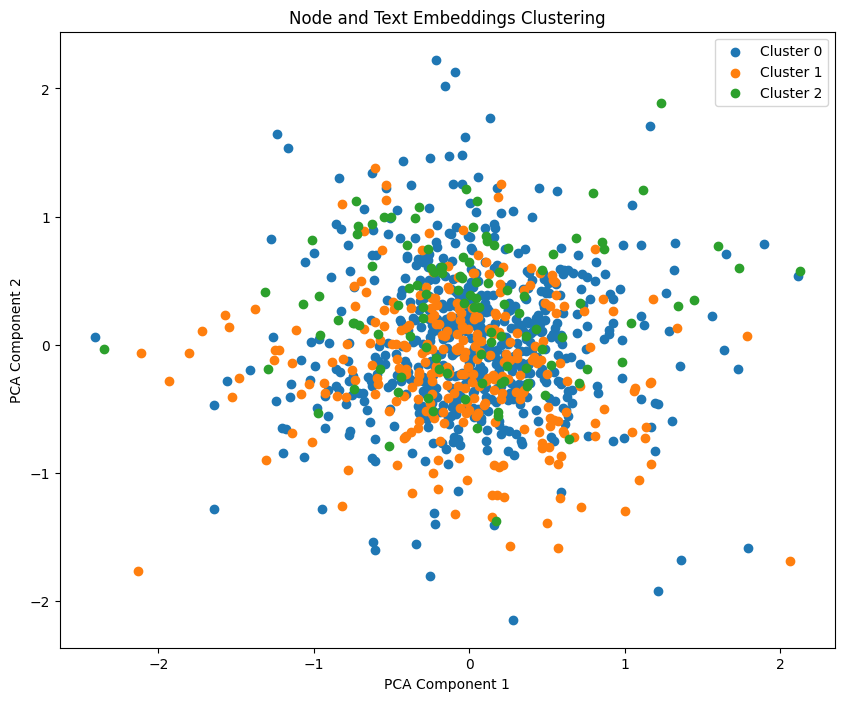

In [16]:
vec_file_path = 'node2vec_embeddings.vec'

print("Loading node embeddings and text data...")
node_embeddings, text_data = load_embeddings_and_text(vec_file_path)

print("Generating embeddings for text data...")
if text_data:
    text_ids, text_vectors = generate_embeddings(text_data, embedding_dim=50)
else:
    text_ids, text_vectors = [], None

print("Combining node and text embeddings...")
combined_embeddings = combine_embeddings_optimized(node_embeddings, text_ids, text_vectors, text_vector_dim=50)

print("Clustering embeddings...")
num_clusters = 3
cluster_labels = cluster_embeddings(combined_embeddings, num_clusters)

print("Visualizing clusters...")
visualize_clusters(combined_embeddings, cluster_labels)

In [6]:
from sklearn.model_selection import train_test_split


def load_rdf_as_triples(rdf_file_path):
    rdf_graph = rdflib.Graph()
    rdf_graph.parse(rdf_file_path, format="turtle") 
    triples = [(str(subj), str(pred), str(obj)) for subj, pred, obj in rdf_graph]
    return triples

def train_transe_model_from_rdf_optimized(triples, output_path, num_epochs=10, embedding_dim=50, batch_size=1024):
    triples_array = np.array(triples, dtype=str)
    triples_factory = TriplesFactory.from_labeled_triples(triples=triples_array)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    train_triples_array, test_triples_array = train_test_split(triples_array, test_size=0.1, random_state=42)
    train_triples_factory = TriplesFactory.from_labeled_triples(triples=train_triples_array)
    test_triples_factory = TriplesFactory.from_labeled_triples(triples=test_triples_array)

    result = pipeline(
        training=train_triples_factory,
        testing=test_triples_factory,
        validation=None,
        model="TransE",
        model_kwargs=dict(embedding_dim=embedding_dim),
        training_kwargs=dict(num_epochs=num_epochs, batch_size=batch_size),
        device=device,
    )

    result.save_to_directory(output_path)

    return result, train_triples_factory

In [ ]:
rdf_file_path = "owlshelves.ttl" 
    output_path = "output_model_dir"
    num_epochs = 20
    embedding_dim = 50
    batch_size = 1024

    print("Loading triples from RDF...")
    triples = load_rdf_as_triples(rdf_file_path)

    print("Training TransE model...")
    transe_result, triples_factory = train_transe_model_from_rdf_optimized(
        triples, output_path, num_epochs=num_epochs, embedding_dim=embedding_dim, batch_size=batch_size
    )

In [7]:
import rdflib
rdf_file_path = "owlshelves.ttl"
triples = load_rdf_as_triples(rdf_file_path)

In [28]:
def load_transe_model():

    model_path = "output_model_dir/trained_model.pkl"# Path to the serialized TransE model
    transe_model = torch.load(model_path, map_location=torch.device("cpu")) # Load the model to CPU
    
def predict_top_books_transe(user_id, top_n=5):

    if not transe_model:  
        raise HTTPException(status_code=500, detail="TransE model not loaded")

    entity_to_id = transe_model.entity_to_id 
    if user_id not in entity_to_id:  
        raise HTTPException(status_code=404, detail=f"User {user_id} not found")

    user_embedding = transe_model.entity_representations[0](
        torch.tensor([entity_to_id[user_id]])
    ).detach().numpy().squeeze()

    similarities = [] 
    for entity, idx in entity_to_id.items():
        if entity.startswith("http://example.org/book"): 
            entity_embedding = transe_model.entity_representations[0](
                torch.tensor([idx])
            ).detach().numpy().squeeze()
            similarity = -((user_embedding - entity_embedding) ** 2).sum()
            similarities.append((entity, similarity))

    top_books = sorted(similarities, key=lambda x: x[1], reverse=True)[:top_n]
    return [book for book, _ in top_books]

def predict_similar_books(book_id, triples_factory, model, top_n=5):
    
    entity_embeddings = model.entity_representations[0]
    all_entities = list(triples_factory.entity_to_id.keys())
    
    if book_id not in triples_factory.entity_to_id:
        raise ValueError(f"Book ID {book_id} not found in the entity set!")
    
    book_idx = triples_factory.entity_to_id[book_id]
    book_embedding = entity_embeddings(torch.tensor(book_idx)).detach().numpy()
    
    similarities = []
    for entity in all_entities:
        if is_valid_isbn(entity) and "rating" not in entity:  # Ensure only books are considered
            entity_idx = triples_factory.entity_to_id[entity]
            entity_embedding = entity_embeddings(torch.tensor(entity_idx)).detach().numpy()
            similarity = -((book_embedding - entity_embedding) ** 2).sum()  # Euclidean distance
            similarities.append((entity, similarity))
    
    # Sort by similarity and return top_n similar books
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return [entity for entity, _ in similarities[:top_n]]

def predict_similar_books_node2vec(book_id, top_n=5):
    
    if not node2vec_model: 
        raise HTTPException(status_code=500, detail="Node2Vec model not loaded")

    try:
        similar_books = node2vec_model.most_similar(book_id, topn=top_n)
        return [book for book, _ in similar_books] # Return only the book IDs
    except KeyError:
        raise HTTPException(status_code=404, detail=f"Book ID {book_id} not found in Node2Vec embeddings")

def compute_virtual_user_embedding(book_ids, triples_factory, model):
    entity_embeddings = model.entity_representations[0]
    print(triples_factory) 
    print(book_ids)
    book_indices = [
        triples_factory.entity_to_id[book_id] for book_id in book_ids if book_id in triples_factory.entity_to_id
    ]
    if not book_indices:
        raise ValueError("None of the provided book IDs exist in the entity set!")
    
    # Get embeddings for the provided books
    book_embeddings = torch.stack([entity_embeddings(torch.tensor(idx)) for idx in book_indices])
    
    # Compute virtual user embedding (e.g., mean of book embeddings)
    virtual_user_embedding = book_embeddings.mean(dim=0)
    return virtual_user_embedding

import re

def is_valid_isbn(isbn):

  isbn = isbn.replace("-", "").replace(" ", "")
  if len(isbn) == 10:
    return is_valid_isbn10(isbn)
  elif len(isbn) == 13:
    return is_valid_isbn13(isbn)
  return False

def is_valid_isbn10(isbn):

  if not isbn[:-1].isdigit() or not (isbn[-1].isdigit() or isbn[-1] in ('X', 'x')):
    return False

  sum = 0
  for i, digit in enumerate(isbn):
    if digit in ('X', 'x'):
      digit = 10
    else:
      digit = int(digit)
    sum += digit * (10 - i)
  return sum % 11 == 0

def is_valid_isbn13(isbn):

  if not isbn.isdigit():
    return False

  sum = 0
  for i, digit in enumerate(isbn):
    digit = int(digit)
    sum += digit * (3 if i % 2 else 1)
  return sum % 10 == 0

def predict_top_books_for_virtual_user(virtual_user_embedding, triples_factory, model, top_n=5):
    entity_embeddings = model.entity_representations[0]
    all_entities = list(triples_factory.entity_to_id.keys())
    similarities = []
    max_id = entity_embeddings.max_id    
    for entity in all_entities:
        if is_valid_isbn(entity) and "rating" not in entity:  # Ensure only books are considered
            entity_idx = triples_factory.entity_to_id[entity]
            if entity_idx >= max_id:
                continue
            entity_embedding = entity_embeddings(torch.tensor(entity_idx)).detach().numpy()
            similarity = -((virtual_user_embedding.detach().numpy() - entity_embedding) ** 2).sum()
            similarities.append((entity, similarity))
    
    # Sort by similarity and return top_n books
    print('hi2')
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    print('hi3')
    return [entity for entity, _ in similarities[:top_n]]

In [26]:
triples_array = np.array([[s, p, o] for s, p, o in triples], dtype=str)
triples_factory = TriplesFactory.from_labeled_triples(triples=triples_array)

In [ ]:
print("Loading pre-trained TransE model...")
transe_model = load_transe_model()

book_ids = [
    "http://example.org/owlshelves#0373117116"
    ]
    
print("Computing virtual user embedding...")
virtual_user_embedding = compute_virtual_user_embedding(book_ids, triples_factory, transe_model)
    
top_n = 5
print(f"Predicting top {top_n} books for virtual user...")
recommended_books = predict_top_books_for_virtual_user(virtual_user_embedding, triples_factory, transe_model, top_n=top_n)
    
print(f"Top {top_n} recommended books for the virtual user:")
for idx, book in enumerate(recommended_books, 1):
    print(f"{idx}. {book}")